In [1]:
#load libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#import dataset

df = pd.read_csv("data/out/hcp_caregap_features.csv", sep = ',')
print(df.shape)
print(df.head(5))
print(df.columns.tolist())

(291983, 23)
          npi specialty_description nppes_provider_state  total_rx  \
0  1003000530     Internal Medicine                   PA     356.0   
1  1003000902       Family Practice                   KY     430.0   
2  1003000936            Cardiology                   SC      22.0   
3  1003001256       Family Practice                   CO      24.0   
4  1003002049         Endocrinology                   CA     723.0   

   patient_volume  first_line  innovative  dpp4  legacy  insulin  ...  \
0            62.0       177.0        24.0  51.0    82.0     22.0  ...   
1            74.0       234.0        55.0  16.0    75.0     50.0  ...   
2             0.0         0.0        22.0   0.0     0.0      0.0  ...   
3             0.0        13.0        11.0   0.0     0.0      0.0  ...   
4           163.0       194.0       203.0  43.0   112.0    150.0  ...   

   pct_dpp4  pct_legacy  pct_insulin   pct_tzd  care_gap_score  \
0  0.143258    0.230337     0.061798  0.000000        0.58756

In [3]:
#structured sanity check

# uniqueness of HCP grain
dups = df.duplicated(subset=["npi","specialty_description","nppes_provider_state"]).sum()
print("duplicate rows at HCP grain:", dups)

# no negative or impossible values
num_cols = ["total_rx","patient_volume","first_line","innovative","legacy","insulin","tzd"]
print((df[num_cols] < 0).sum())

# totals add up
df["cat_sum"] = df[["first_line","innovative","dpp4","legacy","insulin","tzd"]].sum(axis=1)
print("rows where total_rx != sum(categories):", (df["total_rx"].round(6) != df["cat_sum"].round(6)).sum())

duplicate rows at HCP grain: 0
total_rx          0
patient_volume    0
first_line        0
innovative        0
legacy            0
insulin           0
tzd               0
dtype: int64
rows where total_rx != sum(categories): 0


In [4]:
#percentage sanity check

pct_cols = ["pct_first_line","pct_innovative","pct_dpp4","pct_legacy","pct_insulin","pct_tzd"]
pct_stats = df[pct_cols].describe().T
print(pct_stats[["mean","min","max"]])

# rows with any pct outside [0,1]
bad_pct = df[pct_cols].stack().reset_index(level=1, drop=True)
print("pct outside [0,1]:", ((bad_pct < 0) | (bad_pct > 1)).sum())

                    mean  min  max
pct_first_line  0.467525  0.0  1.0
pct_innovative  0.277062  0.0  1.0
pct_dpp4        0.040376  0.0  1.0
pct_legacy      0.091353  0.0  1.0
pct_insulin     0.105886  0.0  1.0
pct_tzd         0.017799  0.0  1.0
pct outside [0,1]: 0


In [5]:
#coverage and distribution

print("HCP count:", len(df))
print("Total Rx (sum):", df["total_rx"].sum())
print("Any zero-volume rows:", (df["total_rx"] == 0).sum())

df["care_gap_score"] = df["care_gap_score"].clip(upper=10)

# quantiles to set sensible thresholds later
print(df[["care_gap_score","innovation_score","total_rx","patient_volume"]].quantile([.1,.25,.5,.75,.9,.95,.99]))

HCP count: 291983
Total Rx (sum): 89029267.0
Any zero-volume rows: 0
      care_gap_score  innovation_score  total_rx  patient_volume
0.10        0.000000          0.000000      16.0             0.0
0.25        0.000000          0.000000      39.0             0.0
0.50        0.373912          0.208537     141.0            22.0
0.75        0.790628          0.377848     385.0            73.0
0.90        1.419350          0.800000     751.0           159.0
0.95        2.605601          1.000000    1085.0           239.0
0.99       10.000000          1.000000    2264.0           535.0


In [6]:
#specialty sanity check

sp = (df.groupby("specialty_description", as_index=False)
        .agg(hcp_n=("npi","nunique"),
             rx_total=("total_rx","sum"),
             gap_mean=("care_gap_score","mean"),
             innov_mean=("innovation_score","mean"))
        .sort_values("rx_total", ascending=False))
sp.head(10)

,specialty_description,hcp_n,rx_total,gap_mean,innov_mean
32,Family Practice,81156,28299511.0,0.597145,0.214549
53,Internal Medicine,61579,25892515.0,0.793820,0.236359
75,Nurse Practitioner,76363,15067123.0,0.870210,0.266375
30,Endocrinology,5974,8383699.0,2.570553,0.361988
94,Physician Assistant,24297,4957593.0,0.634047,0.279314
35,General Practice,4718,2158483.0,0.897651,0.112525
9,Cardiology,9721,888979.0,0.115281,0.820300
37,Geriatric Medicine,1360,503996.0,1.125308,0.155214
68,Nephrology,4211,418807.0,1.876019,0.638177
90,Pharmacist,1202,406110.0,2.161209,0.392343


In [7]:
#state sanity check

st = (df.groupby("nppes_provider_state", as_index=False)
        .agg(hcp_n=("npi","nunique"),
             rx_total=("total_rx","sum"),
             gap_mean=("care_gap_score","mean"),
             innov_mean=("innovation_score","mean"))
        .sort_values("rx_total", ascending=False))
st.head(10)

,nppes_provider_state,hcp_n,rx_total,gap_mean,innov_mean
6,CA,30920,9074575.0,0.737045,0.235920
48,TX,19764,6447447.0,0.731145,0.287445
11,FL,19663,6324459.0,0.829856,0.248504
38,NY,19347,6242140.0,0.681413,0.274239
42,PA,13036,4398637.0,0.820828,0.307746
39,OH,10935,3756151.0,0.888563,0.275284
17,IL,10712,3204588.0,0.786975,0.269111
31,NC,9846,3078522.0,0.834067,0.331889
25,MI,10101,2973149.0,0.752054,0.278073
12,GA,7444,2700865.0,0.806024,0.307516


In [8]:
#flag counts

flag_counts = {
    "high_gap": int(df["flag_high_gap"].sum()),
    "innovator": int(df["flag_innovator"].sum()),
    "guideline_aligned": int(df["flag_guideline_aligned"].sum()),
    "dpp4": int(df["flag_dpp4_heavy"].sum())
}
flag_counts

{'high_gap': 2207,
 'innovator': 66363,
 'guideline_aligned': 122061,
 'dpp4': 6807}

In [9]:
#extremes

# highest gap & volume (most concerning)
hi_gap = df.sort_values(["care_gap_score","total_rx"], ascending=[False,False]).head(20)
hi_gap[["npi","specialty_description","nppes_provider_state","total_rx","patient_volume","care_gap_score","innovation_score"]]

,npi,specialty_description,nppes_provider_state,total_rx,patient_volume,care_gap_score,innovation_score
85263,1295047298,Family Practice,OH,2915.0,589.0,10.0,0.467925
95532,1326357294,Nurse Practitioner,OH,2409.0,621.0,10.0,0.341220
266854,1912356700,Internal Medicine,TX,1914.0,320.0,10.0,0.421891
278125,1952366452,Internal Medicine,PA,1889.0,82.0,10.0,0.046585
206295,1700804671,Endocrinology,ME,1827.0,488.0,10.0,0.174603
159590,1548500333,Endocrinology,MI,1616.0,416.0,10.0,0.412748
173686,1598352288,Nurse Practitioner,OH,1581.0,415.0,10.0,0.341556
233121,1790856680,Nurse Practitioner,CA,1461.0,568.0,10.0,0.226557
222701,1760431159,Endocrinology,OH,1358.0,236.0,10.0,0.290869
16432,1053656561,Endocrinology,FL,1348.0,352.0,10.0,0.160237


In [10]:
# highest innovation
hi_innov = df.sort_values("innovation_score", ascending=False).head(20)
hi_innov[["npi","specialty_description","nppes_provider_state","total_rx","innovation_score","pct_first_line"]]

,npi,specialty_description,nppes_provider_state,total_rx,innovation_score,pct_first_line
62515,1215277363,Physician Assistant,MO,24.0,1.0,0.0
251143,1861016172,Nurse Practitioner,PA,52.0,1.0,0.0
129221,1447241922,Cardiology,MA,11.0,1.0,0.0
251145,1861016826,Physician Assistant,NY,12.0,1.0,0.0
220713,1750585113,Nephrology,FL,36.0,1.0,0.0
29427,1104137405,Cardiology,NC,36.0,1.0,0.0
29428,1104137520,Internal Medicine,GA,18.0,1.0,0.0
251144,1861016602,Internal Medicine,WA,11.0,1.0,0.0
29432,1104138775,Internal Medicine,NJ,35.0,1.0,0.0
275945,1942468657,Nephrology,IN,21.0,1.0,0.0


In [11]:
#recompute flags

gap_thr = df["care_gap_score"].quantile(0.9)      # top 10% gap
innov_thr = df["innovation_score"].quantile(0.9)  # top 10% innovation
dpp4_thr  = df["pct_dpp4"].quantile(0.9)         # top 10% dpp4
firstline_lo = df["pct_first_line"].quantile(0.2) # bottom 20% first-line

df["flag_high_gap_q"]  = (df["care_gap_score"] >= gap_thr) & (df["pct_first_line"] <= firstline_lo)
df["flag_innovator_q"] = (df["innovation_score"] >= innov_thr)
df["flag_dpp4_heavy_q"] = (df["pct_dpp4"] >= dpp4_thr)


df[["flag_high_gap_q","flag_innovator_q","flag_dpp4_heavy_q"]].mean().round(3)  # should be ~0.1 each

flag_high_gap_q      0.075
flag_innovator_q     0.100
flag_dpp4_heavy_q    0.100
dtype: float64

In [12]:
# Cap extreme values for care_gap_score
df["care_gap_score"] = df["care_gap_score"].clip(upper=10)

# Quantile thresholds
gap_thr   = df["care_gap_score"].quantile(0.90)
innov_thr = df["innovation_score"].quantile(0.90)
dpp4_thr  = df["pct_dpp4"].quantile(0.90)
firstline_lo = df["pct_first_line"].quantile(0.20)

# Flags
df["flag_high_gap_q"]   = (df["care_gap_score"] >= gap_thr) & (df["pct_first_line"] <= firstline_lo)
df["flag_innovator_q"]  = (df["innovation_score"] >= innov_thr)
df["flag_dpp4_heavy_q"] = (df["pct_dpp4"] >= dpp4_thr)

# Combine into segment label
def assign_segment(row):
    if row["flag_high_gap_q"]: return "High Gap"
    if row["flag_innovator_q"]: return "Innovator"
    if row["flag_dpp4_heavy_q"]: return "DPP-4 Heavy"
    if (row["pct_first_line"] > 0.4) and (row["pct_legacy"] < 0.15): return "Guideline-Aligned"
    return "Other"

df["segment"] = df.apply(assign_segment, axis=1)
df["segment"].value_counts(normalize=True).round(3)

segment
Guideline-Aligned    0.382
Other                0.353
Innovator            0.099
DPP-4 Heavy          0.090
High Gap             0.075
Name: proportion, dtype: float64

In [13]:
import pandas as pd

def _ensure_cols(df, cols):
    for c in cols:
        if c not in df.columns:
            df[c] = 0.0
    return df


## Visuals

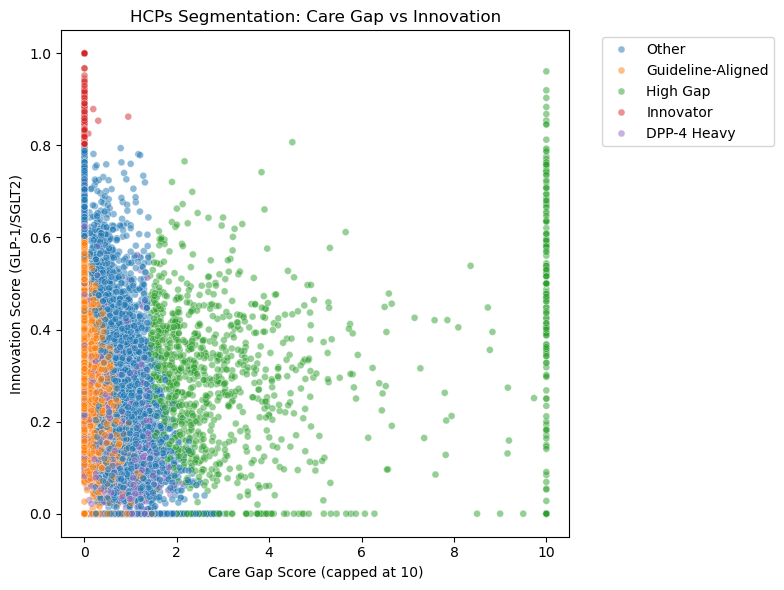

In [14]:
#scatter with segments

import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df.sample(20000, random_state=42),
    x="care_gap_score", y="innovation_score",
    hue="segment", alpha=0.5, s=25
)
plt.title("HCPs Segmentation: Care Gap vs Innovation")
plt.xlabel("Care Gap Score (capped at 10)")
plt.ylabel("Innovation Score (GLP-1/SGLT2)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

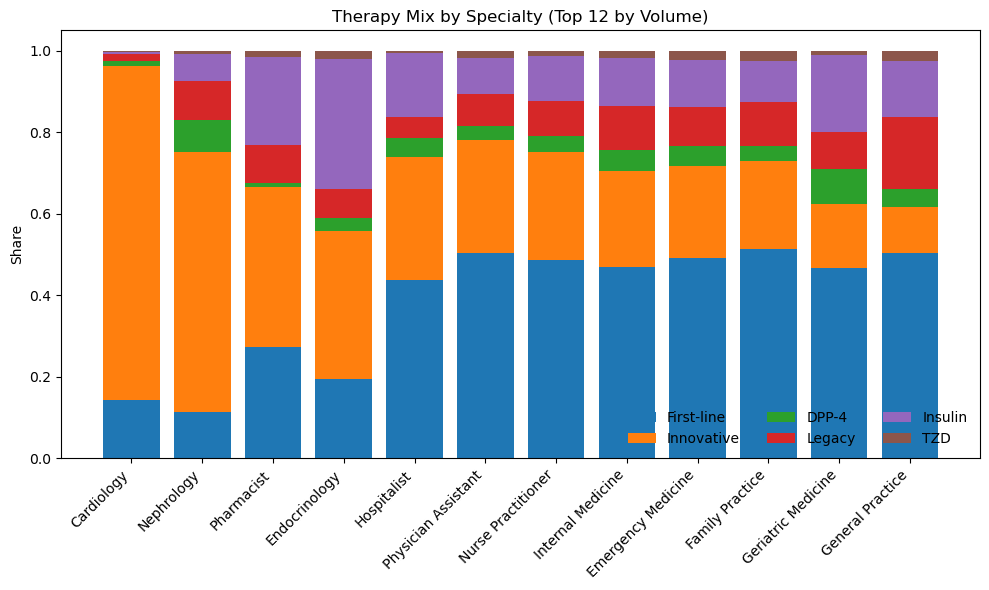

In [18]:
#stacked by specialty

def stacked_shares_by_specialty(hcp_df, top_n=10, save=None):
    cols_req = ["pct_first_line","pct_innovative","pct_dpp4","pct_legacy","pct_insulin","pct_tzd",
                "specialty_description","total_rx"]
    h = _ensure_cols(hcp_df.copy(), cols_req)

    # pick top specialties by total volume
    top_specs = (h.groupby("specialty_description", as_index=False)
                   .agg(total=("total_rx","sum"))
                   .sort_values("total", ascending=False)
                   .head(top_n)["specialty_description"])
    sub = h[h["specialty_description"].isin(top_specs)].copy()

    # mean pct per specialty (unweighted; change to weighted by total_rx if you prefer)
    agg = (sub.groupby("specialty_description", as_index=False)
              .agg(p_first=("pct_first_line","mean"),
                   p_innov=("pct_innovative","mean"),
                   p_dpp4=("pct_dpp4","mean"),
                   p_legacy=("pct_legacy","mean"),
                   p_ins=("pct_insulin","mean"),
                   p_tzd=("pct_tzd","mean"))
              .sort_values("p_innov", ascending=False))

    labels = agg["specialty_description"].tolist()
    data = agg[["p_first","p_innov","p_dpp4","p_legacy","p_ins","p_tzd"]].to_numpy()

    plt.figure(figsize=(10,6))
    bottom = np.zeros(len(labels))
    names = ["First-line","Innovative","DPP-4","Legacy","Insulin","TZD"]
    for i in range(data.shape[1]):
        plt.bar(labels, data[:, i], bottom=bottom, label=names[i])
        bottom += data[:, i]
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Share")
    plt.title(f"Therapy Mix by Specialty (Top {top_n} by Volume)")
    plt.legend(frameon=False, ncol=3)
    plt.tight_layout()
    if save: plt.savefig(save, dpi=200)
    plt.show()

# Usage:
stacked_shares_by_specialty(df, top_n=12, save="shares_by_specialty.png")

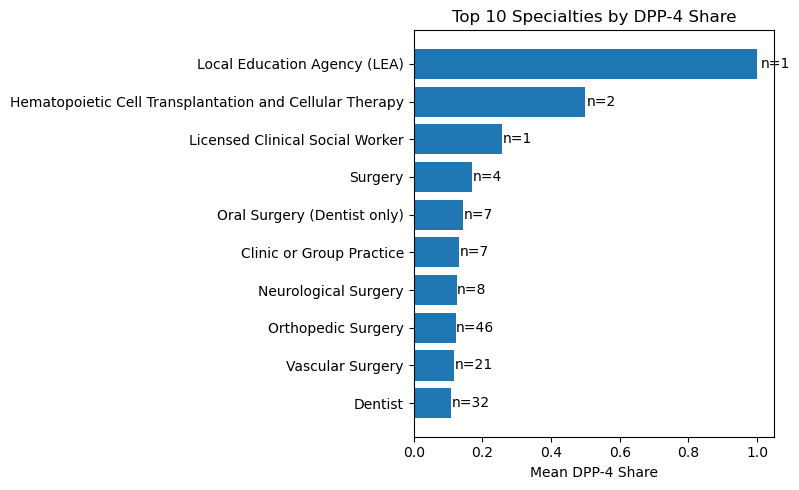

In [19]:

def top_specialties_dpp4(hcp_df, top_n=10, save=None):
    h = _ensure_cols(hcp_df.copy(), ["pct_dpp4","npi","specialty_description","total_rx"])
    sp = (h.groupby("specialty_description", as_index=False)
            .agg(mean_dpp4=("pct_dpp4","mean"),
                 n_phys=("npi","nunique"),
                 rx_total=("total_rx","sum"))
            .sort_values("mean_dpp4", ascending=False)
            .head(top_n))

    plt.figure(figsize=(8,5))
    plt.barh(sp["specialty_description"][::-1], sp["mean_dpp4"][::-1])
    plt.xlabel("Mean DPP-4 Share")
    plt.title(f"Top {top_n} Specialties by DPP-4 Share")
    for i, (n, rx) in enumerate(zip(sp["n_phys"][::-1], sp["rx_total"][::-1])):
        plt.text(sp["mean_dpp4"][::-1].iloc[i]*1.01, i, f"n={n}", va="center")
    plt.tight_layout()
    if save: plt.savefig(save, dpi=200)
    plt.show()

# Usage:
top_specialties_dpp4(df, save="top_specialties_dpp4.png")


In [21]:
pip install plotly

  Using cached plotly-6.3.0-py3-none-any.whl.metadata (8.5 kB)
Using cached plotly-6.3.0-py3-none-any.whl (9.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]━━━━ 1/2 [plotly]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/ericabrooks/anaconda3/envs/DS-7337/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


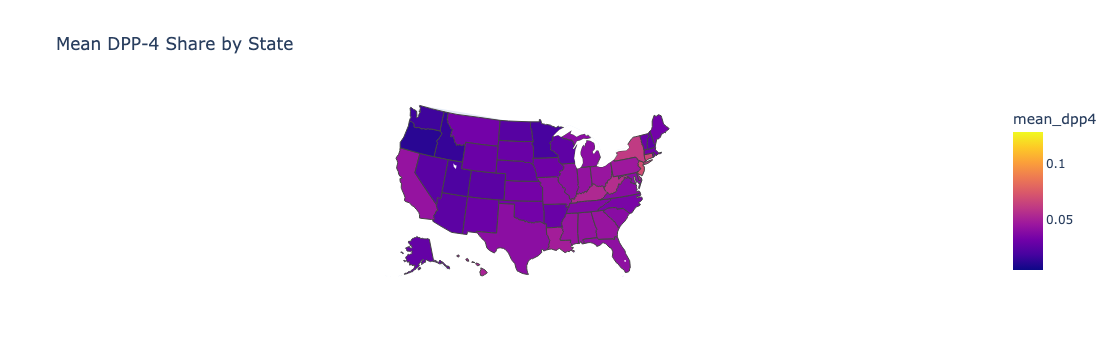

In [14]:
import plotly.express as px

def choropleth_state_dpp4(hcp_df, save_html=None, save_pdf=None):
    h = _ensure_cols(hcp_df.copy(), ["nppes_provider_state","pct_dpp4","npi"])
    st = (h.groupby("nppes_provider_state", as_index=False)
            .agg(mean_dpp4=("pct_dpp4","mean"),
                 n_phys=("npi","nunique")))
    fig = px.choropleth(
        st, locations="nppes_provider_state", locationmode="USA-states",
        color="mean_dpp4", scope="usa", hover_data=["n_phys"],
        title="Mean DPP-4 Share by State"
    )
    if save_html:
        fig.write_html(save_html, include_plotlyjs="cdn")
    if save_pdf:
        fig.write_image(save_pdf, scale=2)  # static image for the PDF
    fig.show()

# Usage:
#choropleth_state_dpp4(df, save_html="state_dpp4.html")
choropleth_state_dpp4(df, save_pdf="state_dpp4.png")

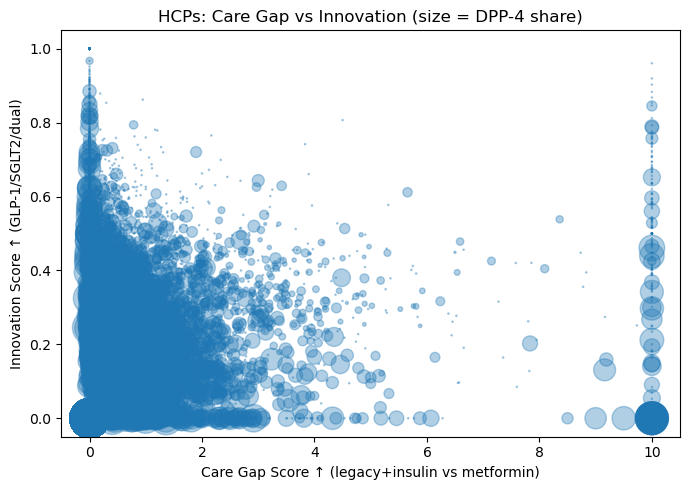

In [25]:
# scatter care gap vs innovation

def scatter_gap_innov_size_dpp4(hcp_df, sample=20000, save=None):
    h = _ensure_cols(hcp_df.copy(),
                     ["care_gap_score","innovation_score","pct_dpp4"])
    # optional sampling for speed/clarity
    if len(h) > sample:
        h = h.sample(sample, random_state=42)

    # scale sizes (avoid zero)
    s = (h["pct_dpp4"].fillna(0).to_numpy() + 0.001) * 800

    plt.figure(figsize=(7,5))
    plt.scatter(h["care_gap_score"], h["innovation_score"], s=s, alpha=0.35)
    plt.xlabel("Care Gap Score ↑ (legacy+insulin vs metformin)")
    plt.ylabel("Innovation Score ↑ (GLP-1/SGLT2/dual)")
    plt.title("HCPs: Care Gap vs Innovation (size = DPP-4 share)")
    plt.tight_layout()
    if save: plt.savefig(save, dpi=200)
    plt.show()

# Usage:
scatter_gap_innov_size_dpp4(df, save="scatter_gap_innov_dpp4.png")

In [28]:
#per-specialty summary table

def specialty_profile_table(hcp_df, weighted=True, round_to=3):
    # Ensure required columns exist
    needed = [
        "pct_first_line","pct_innovative","pct_dpp4","pct_legacy","pct_insulin","pct_tzd",
        "care_gap_score","innovation_score","npi","specialty_description","total_rx"
    ]
    df = hcp_df.copy()
    for c in needed:
        if c not in df.columns:
            df[c] = 0.0

    if weighted:
        # volume-weighted means by specialty
        def wmean(g, col):
            w = g["total_rx"]
            x = g[col]
            denom = w.sum()
            return (x * w).sum() / denom if denom != 0 else float("nan")

        rows = []
        for sp, g in df.groupby("specialty_description", dropna=False):
            rows.append({
                "specialty_description": sp,
                "hcp_n": g["npi"].nunique(),
                "rx_total": g["total_rx"].sum(),
                "first":  wmean(g, "pct_first_line"),
                "innov":  wmean(g, "pct_innovative"),
                "dpp4":   wmean(g, "pct_dpp4"),
                "legacy": wmean(g, "pct_legacy"),
                "insulin":wmean(g, "pct_insulin"),
                "tzd":    wmean(g, "pct_tzd"),
                "gap":    wmean(g, "care_gap_score"),
                "innov_score": wmean(g, "innovation_score"),
            })
        prof = pd.DataFrame(rows)
    else:
        # simple unweighted means
        prof = (df.groupby("specialty_description", as_index=False)
                  .agg(hcp_n=("npi","nunique"),
                       rx_total=("total_rx","sum"),
                       first=("pct_first_line","mean"),
                       innov=("pct_innovative","mean"),
                       dpp4=("pct_dpp4","mean"),
                       legacy=("pct_legacy","mean"),
                       insulin=("pct_insulin","mean"),
                       tzd=("pct_tzd","mean"),
                       gap=("care_gap_score","mean"),
                       innov_score=("innovation_score","mean"))
               )

    # Sort by volume and round for display
    prof = prof.sort_values("rx_total", ascending=False)
    num_cols = ["rx_total","first","innov","dpp4","legacy","insulin","tzd","gap","innov_score"]
    prof[num_cols] = prof[num_cols].round(round_to)

    return prof

# Usage:
prof = specialty_profile_table(df, weighted=True)
display(prof.head(20))
prof.to_csv("data/out/specialty_profile_table.csv", index=False)

,specialty_description,hcp_n,rx_total,first,innov,dpp4,legacy,insulin,tzd,gap,innov_score
32,Family Practice,81156,28299511.0,0.416,0.217,0.052,0.139,0.139,0.036,0.779,0.217
53,Internal Medicine,61579,25892515.0,0.389,0.218,0.065,0.138,0.161,0.029,0.951,0.218
75,Nurse Practitioner,76363,15067123.0,0.364,0.272,0.048,0.113,0.181,0.023,1.303,0.272
30,Endocrinology,5974,8383699.0,0.187,0.326,0.034,0.092,0.333,0.027,2.595,0.326
94,Physician Assistant,24297,4957593.0,0.380,0.280,0.044,0.107,0.161,0.028,1.105,0.280
35,General Practice,4718,2158483.0,0.411,0.111,0.057,0.205,0.181,0.035,1.046,0.111
9,Cardiology,9721,888979.0,0.214,0.663,0.030,0.057,0.027,0.009,0.284,0.663
37,Geriatric Medicine,1360,503996.0,0.359,0.153,0.097,0.112,0.262,0.017,1.334,0.153
68,Nephrology,4211,418807.0,0.171,0.493,0.091,0.118,0.111,0.017,2.068,0.493
90,Pharmacist,1202,406110.0,0.280,0.286,0.008,0.151,0.254,0.020,1.892,0.286


In [29]:

def specialty_profile_table(
    hcp_df,
    weighted=True,
    round_to=3,
    min_hcp=50,
    min_rx=10_000,
    top_n=20
):
    """
    Build a specialty-level summary table with filtering.
    - weighted: use Rx-volume weighted means for pct/score columns.
    - min_hcp:  keep specialties with at least this many unique NPIs.
    - min_rx:   keep specialties with total_rx >= this threshold.
    - top_n:    after filtering, keep only the top-N by rx_total.
    """
    # Ensure required columns exist
    needed = [
        "pct_first_line","pct_innovative","pct_dpp4","pct_legacy","pct_insulin","pct_tzd",
        "care_gap_score","innovation_score","npi","specialty_description","total_rx"
    ]
    df = hcp_df.copy()
    for c in needed:
        if c not in df.columns:
            df[c] = 0.0

    if weighted:
        def wmean(g, col):
            w = g["total_rx"]
            x = g[col]
            den = w.sum()
            return (x * w).sum() / den if den != 0 else float("nan")

        rows = []
        for sp, g in df.groupby("specialty_description", dropna=False):
            rows.append({
                "specialty_description": sp,
                "hcp_n": g["npi"].nunique(),
                "rx_total": g["total_rx"].sum(),
                "first":  wmean(g, "pct_first_line"),
                "innov":  wmean(g, "pct_innovative"),
                "dpp4":   wmean(g, "pct_dpp4"),
                "legacy": wmean(g, "pct_legacy"),
                "insulin":wmean(g, "pct_insulin"),
                "tzd":    wmean(g, "pct_tzd"),
                "gap":    wmean(g, "care_gap_score"),
                "innov_score": wmean(g, "innovation_score"),
            })
        prof = pd.DataFrame(rows)
    else:
        prof = (df.groupby("specialty_description", as_index=False)
                  .agg(hcp_n=("npi","nunique"),
                       rx_total=("total_rx","sum"),
                       first=("pct_first_line","mean"),
                       innov=("pct_innovative","mean"),
                       dpp4=("pct_dpp4","mean"),
                       legacy=("pct_legacy","mean"),
                       insulin=("pct_insulin","mean"),
                       tzd=("pct_tzd","mean"),
                       gap=("care_gap_score","mean"),
                       innov_score=("innovation_score","mean"))
               )

    # ---- Filters ----
    if min_hcp is not None:
        prof = prof[prof["hcp_n"] >= min_hcp]
    if min_rx is not None:
        prof = prof[prof["rx_total"] >= min_rx]

    # Sort by volume and keep top N
    prof = prof.sort_values("rx_total", ascending=False)
    if top_n is not None:
        prof = prof.head(top_n)

    # Round numeric columns for display
    num_cols = ["rx_total","first","innov","dpp4","legacy","insulin","tzd","gap","innov_score"]
    prof[num_cols] = prof[num_cols].round(round_to)

    # Reorder columns
    prof = prof[[
        "specialty_description","hcp_n","rx_total",
        "first","innov","dpp4","legacy","insulin","tzd",
        "gap","innov_score"
    ]]

    return prof

In [30]:
# Default: weighted means, min 50 HCPs & 10k Rx, top 20 by volume
prof = specialty_profile_table(df)

# Stricter filter: min 100 HCPs, 50k Rx; show top 12
prof_strict = specialty_profile_table(df, min_hcp=100, min_rx=50_000, top_n=12)

# Unweighted means, show more rows
prof_unweighted = specialty_profile_table(df, weighted=False, min_hcp=30, min_rx=5_000, top_n=30)

# Save
prof.to_csv("data/out/specialty_profile_table_filtered.csv", index=False)